# Modern Neural Networks - Notebook 3

This notebook will continue on from Notebook 2 of Modern Neural Networks and dive into the OOP-style development of CNN (LeNet-5) with TensorFlow 2 along with an experiment on different Optimisers.

Previously, using only Gradient Descent, the models were able to achieve around an impressive 99.49% accuracy score and a validation accuracy score of 98.77%. These model ran for about 30 minutes (implemented with our own Convolutionx) and 20 minutes (implemented with TF Conv2D) repectively.

### Import the required libraries:

In [1]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import timeit

In [2]:
import os
from IPython.display import display, Image
import matplotlib.pyplot as plt

# %matplotlib inline

# Set up the working directory for the images:
image_folderName = 'Description Images'
image_path = os.path.abspath(image_folderName) + '/'

## 4 - Refining the Training Process:

Neural Networks has also improved on reliability and having a faster convergence rate towards a solution over years. Previously, the LeNet-5 model implemented utilises the Gradient Descent algorithm, although, it was able to get hte job done, it does have its shortcomings. More modern techniques of optimisers builds on these shortcomings and have been developed to produce better results. 

## 4.1 - Gradient Descent Algorithm Shortcomings:

As mentioned earlier, a neural network can consists of a large number of parameters to compute for, as it is a combination of all the weights and bias parameters through all the layers, where these are iteratively being updated by miniising the Loss function through the process of backpropagation. 

As a refresher, the equation for the Gradient Descent process can be summed into the following:

$$ P_{i+1} \leftarrow P_{i} - v_{i} $$ with $$ v_{i} = \epsilon \frac{d \mathbf{L_{i}}}{d \mathbf{P_{i}}}$$ 

Where,
- $ \epsilon $ is the learning rate hyperparameter.

This __Learning Rate__ has to be set with care to ensure that the convergence to a solution can be found. However, in practice, this can be a challenge to optimise for. 

The reasons for caution when setting the learning rate can be broken into three points:
1. Training speed and trade-off
2. Suboptimal local minima
3. Using a single hyperparameter for heterogeneous parameters

### 4.1.1 - Training speed and trade-off:

This is a problem when setting the learning rate to be too high to allow the model to train and converge to a solution faster, but it can also prevent the model from finding the optimal loss minimum. This can be seen in the diagram below:

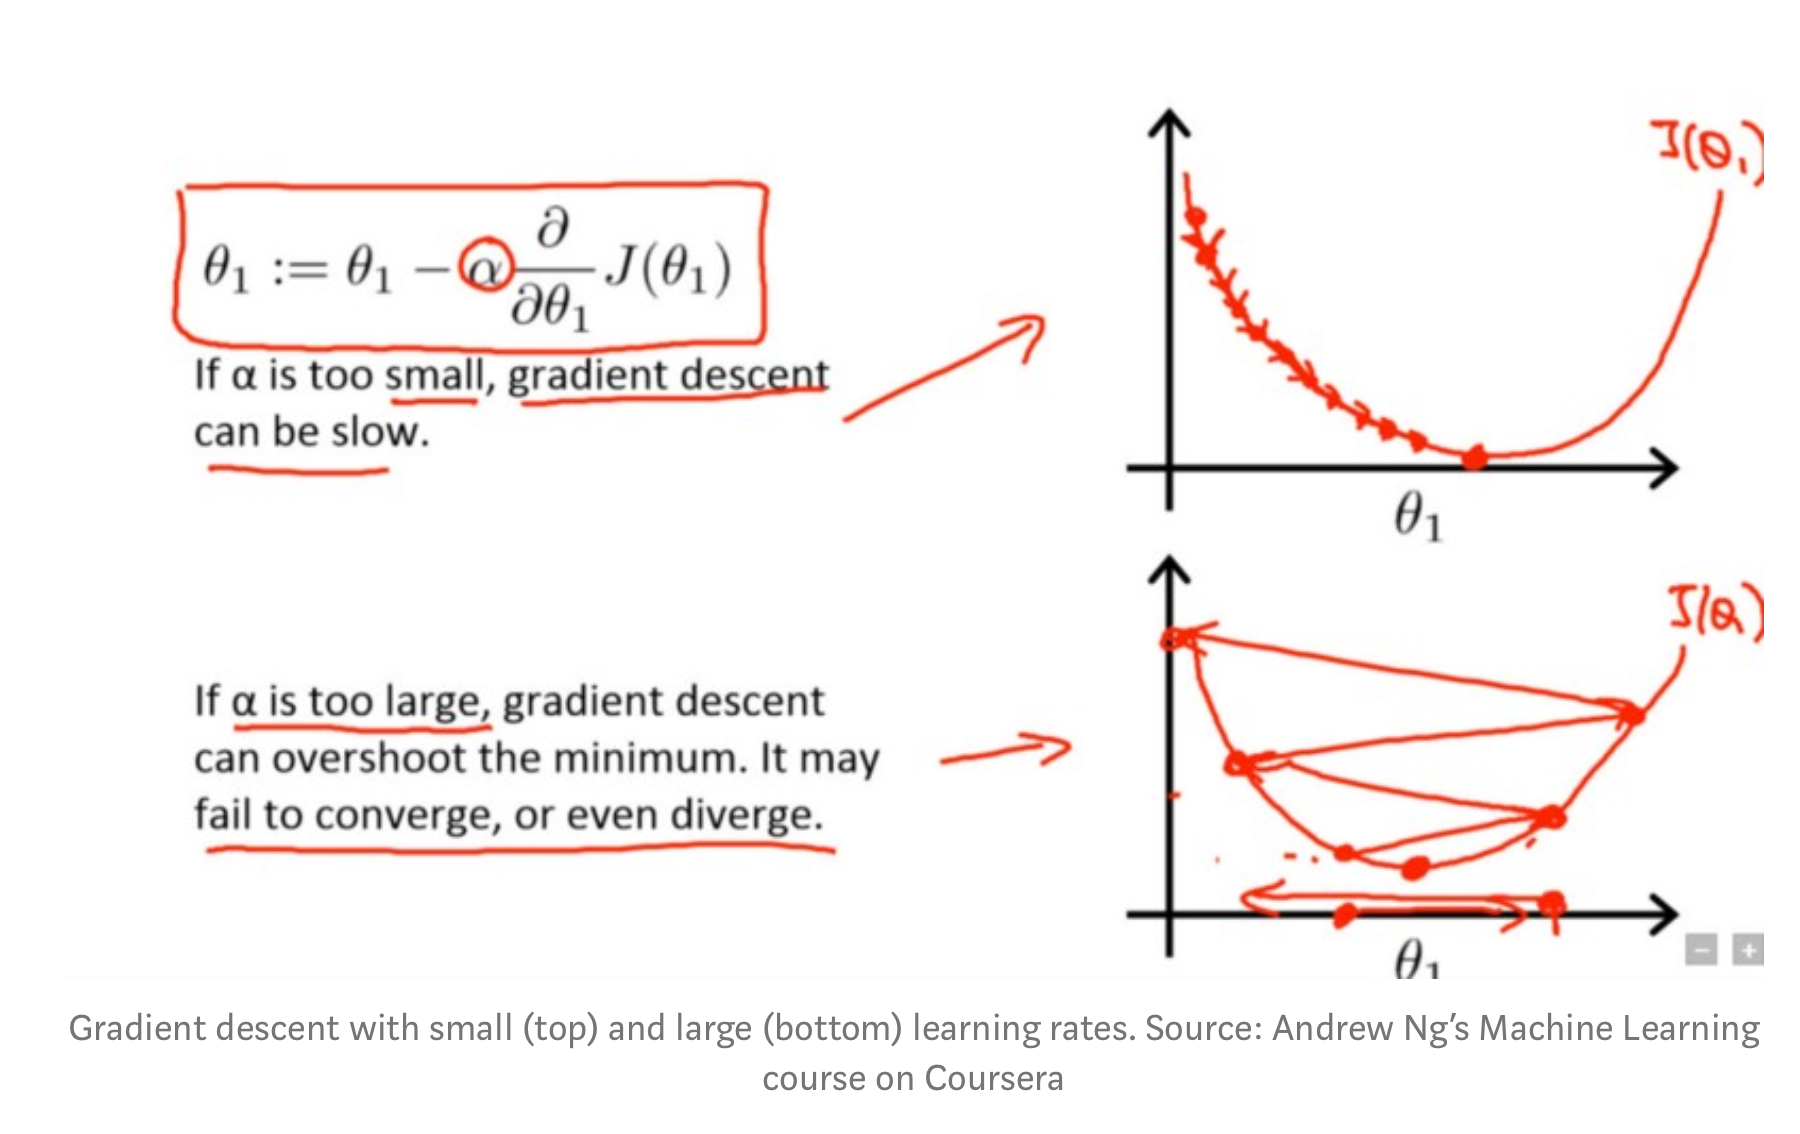

Image ref -> https://towardsdatascience.com/understanding-learning-rates-and-how-it-improves-performance-in-deep-learning-d0d4059c1c10


In [3]:
# Learning Rate of Gradient Descent: 
display(Image(image_path + 'SGD Learning Rate.png', width=600, unconfined=True))
print('Image ref -> https://towardsdatascience.com/understanding-learning-rates-and-how-it-improves-performance-in-deep-learning-d0d4059c1c10')

As it can be seen, when the learning rate is set to be very low, the convergence has slowed down, whereas if the learning rate was set to be very high, the model overshoots the local minima. To find the best solution will require a long an iterative process of trial and error. One of the more common way to aid the process along would be to use __Learning Rate Decay__ where it dynamically adjusts the learning rate during the training process. It will start with a large value and progressively decreases after each epoch. 

### 4.1.2 - Suboptimal Local Minima:

Sometimes the gradient descent algorithm can get stuck in a local minima that is not the optimal solution compared to the actual global minima. This can be seen in the diagram below:

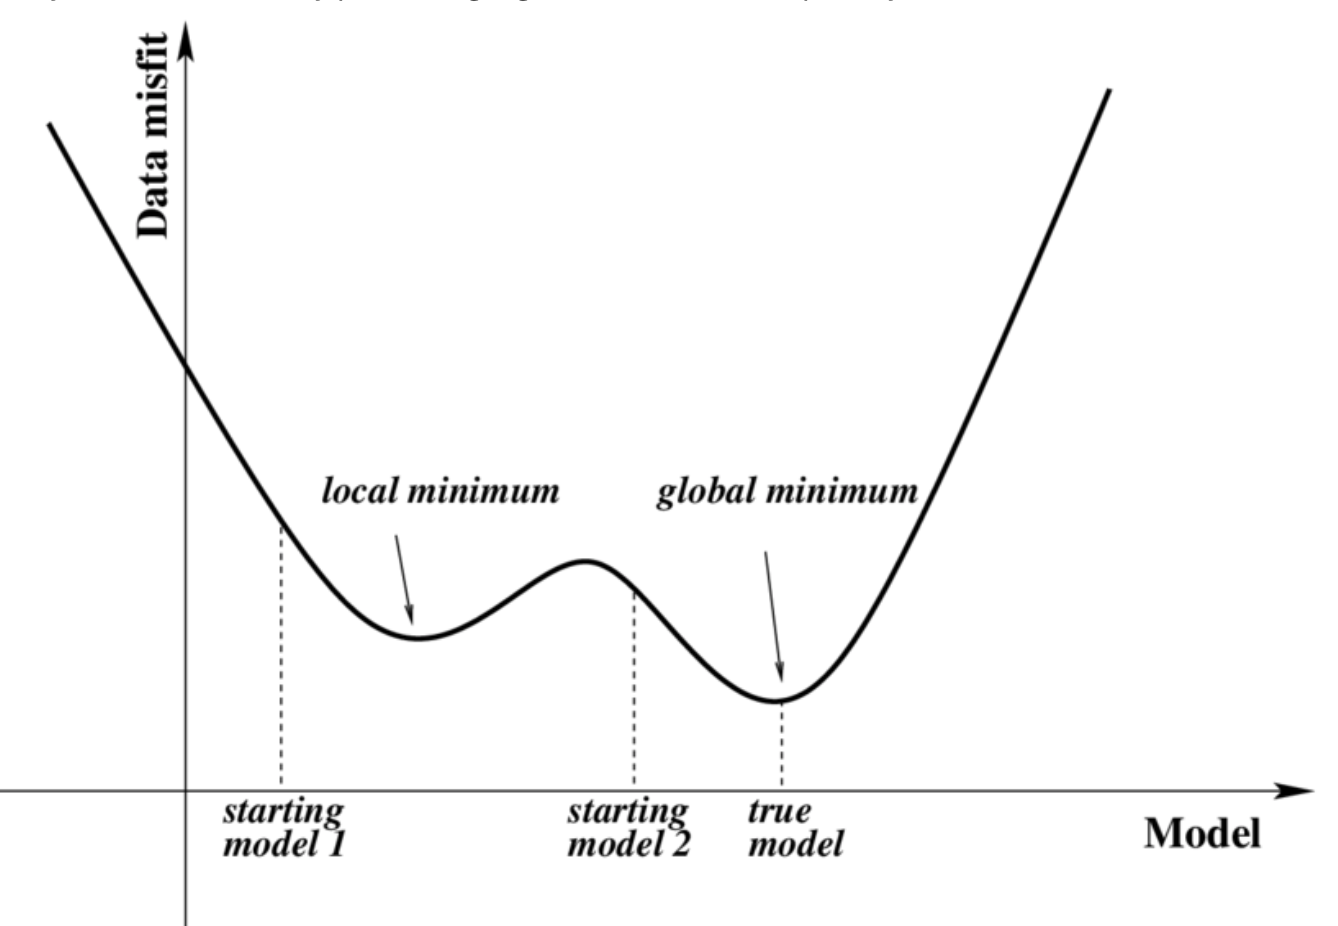

Image ref -> https://www.kaggle.com/c/dauphine-203-machine-learning-competition-2020/discussion/137389


In [4]:
# Suboptimal Local Minima: 
display(Image(image_path + 'SGD Local Minima.png', width=600, unconfined=True))
print('Image ref -> https://www.kaggle.com/c/dauphine-203-machine-learning-competition-2020/discussion/137389')

It should be mentioned that in the previous model training, the algorithm was able to find the global minimum was due to the random sampling of training data samples. This is one way to prevent the model from getting stuck in the local minima. It should also be noted that the gradient descent algorithm does not guarantee a convergences to the global minimum as this can be complex at times. 

### 4.1.3 - A Single Hyperparameter for heterogeneous parameters:

Lastly, the gradient descent algorithm for the model does use the same learning rate for training and thus updates all of the parameters of the network. However, it can be said that not all of these variables or loss function are sensitive to the learning rate used or the changes in learning rate being used.

Intuitively, this means that a better result can be achieved if there are different learning rates to be used with crucial parameters that are more careful while using bolder learning rates to update parameters that do not impact the model as much.

## 4.2 - Advanced Optimisers:

To overcome these shortcomings of the Gradient Descent, more modern optimisation techniques were introduced. The techniques discussed here are:
1. Momentum Algorithms
2. Ada Family (Adagrad, Adadelta and Adam)

## 4.2.1 - Momentum Algorithms:

Momentum algorithms are built on top of the Stochastic Gradient Descent algorithm where it introduces the physics notion of momentum. When applied to Gradient Descent, it takes the previous parameter updates $ v_{i-1} $ and adding it to the new update term $ v_{i} $. This can be seen in the following equation:

$$ v_{i} = \epsilon \frac{d \mathbf{L_{i}}}{d \mathbf{P_{i}}} + \mu v_{i-1} $$

Where,
- $ \mu $ is the momentum weighing that has a value from 0 to 1, it defines the fraction of the previous update $ v_{i-1} $ to be applied.

Intuitively, if the current and previous steps are in the same direction, the combined magnitudes would add up thus accelerating the Stochastic Gradient Descent towards the relevant direction. However, if the direction is different, the momentum will dampen the oscillations.

#### TF has these within the "optimizers" module, and can be seen in the following code block:

This optimiser instance can be passed as a parameter to the "model.fit()" method of the Keras API.

In [5]:
optimiser = tf.optimizers.SGD(learning_rate=0.01,
                              momentum=0.9,
                              decay = 0.0,
                              nesterov=False,
                              name='SGD')

#### The following code block shows an example of a simple training step that is implemented manually: 

This can be used in more complex tranining situations where the optimiser can be called. It provides the loss gradient and trainable model parameters.

In [6]:
@tf.function
def train_step(batch_images, batch_gts):
    
    # TF to tape the gradients:
    with tf.GradientTape() as grad_tape:
        
        # Forward pass:
        batch_preds = model(batch_images, training = True)
        
        # Compute the loss:
        loss = tf.losses.MSE(batch_gts, batch_preds)
        
    # Obtain the loss gradients w.r.t trainable parameters and backpropagate the results:
    grads = grad_tape.gradient(loss, model.trainable_variables)
    optimiser.apply_gradients( zip(grads, model.trainable_variables) )

The "tf.optimizers.SGD()" method also includes a "nesterov" Boolean parameter that can be set to True or False. 

Another major problem is that when the network gets too close to the loss minimum, the accumulated momentum can be large and may cause it to miss the targeted minimum. This is where __Nesterov accelerated gradient (NAG)__ comes in with the solution. It gives the optimiser the possibility to look at the slope ahead thus allowing it to know if it need to slow down when the slope is starting to go up again. 

It uses the past term $ v_{i-1} $ to estimate the values of $P_{i+1}$ which is the parameters to take for following this direction. The gradient is then evaluated w.r.t approximate future parameters. It is then used to compute the actual update as follows:

$$ P_{i+1} \leftarrow P_{i} - v_{i} $$ with $$ v_{i} = \epsilon \frac{d \mathbf{L_{i}}}{d \mathbf{ (P_{i} - \mu v_{i-1}) }} + \mu v_{i-1}$$ 

## 4.2.2 - Ada Family (Adagrad, Adadelta and Adam):

The Ada family of algorithms are based on adapting the learning rate depending on the sensitivity of each neuron. This sensitivity can also bedescribed as the activation frequency of the neurons. 

The __Adagrad__ optimiser automatically decrease the learning rate more quickly when the parameters are linked to features that are commonly found while the learning rate decreases even more slowly for features that are infrequent. This technique provide a stochastic gradient descent process that is more stable and it also removes the need to manually adpat or decay the learning rate. This is useful for datasets with sparse representations.

The __Adadelta__ optimiser builds on a problem that is inherent to Adagrad, that is when the learning rate becomes too small for the network to learn as the decay rate of the learning rate increases at each iteration. It avoids this problem by keeping making sure the factors used to divide the learning rate for each parameter is kept in check.

The __Adam__ optimiser stores the previous update terms $v_{i} $ in order to adapt the learning rate for each of the parameter coupled with sstoring the past momentum values as well. This can be seen to be a technique between Adadelta and Momentum. 

All these optimisers can be found in the TF's "optimizers" module.

## 4.2.3 - TF and Keras Implementations:

### Load in the Data:

In [7]:
# Define the number of classes:
nb_classes = 10

# Define the image dimensions:
img_rows, img_cols, img_chnls = 28, 28, 1

# Define the input shape:
input_shape = (img_rows, img_cols, img_chnls)

# Load in the dataset:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

### Data Preprocessing:

NOTE: the "*input_shape" where the single " * " notation in the code means a to create a tuple from this argument. where two " * " like " ** " is to create a dictionary.

In [8]:
# Normalise the data:
x_train, x_test = x_train / 255.0, x_test / 255.0

# Inspect:
x_train.shape, x_test.shape

((60000, 28, 28), (10000, 28, 28))

In [9]:
# Reshape the inputs:
x_train = x_train.reshape(x_train.shape[0], *input_shape)
x_test = x_test.reshape(x_test.shape[0], *input_shape)

# Inspect:
x_train.shape, x_test.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

### Instantiate the Model:

Here, the LeNet-5 model from the previous sections (previous notebooks 2) will be implemented again, but it will be implemented in the format of "Keras Sequential API". The model will be using "tf.keras.Sequential" where it is a class that will inherit from the "tf.keras.Model" module to make sequential architecture. 

The model will also be wrapped so into a function, so that it can be reuse/spawned for multiple times.

In [10]:
# Import the required libraries:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D

In [11]:
# Build the model: Keras Sequential API:
def lenet(name='lenet'):
    model = Sequential(name = name)
    
    # 1st Convolutional Block:
    model.add(Conv2D(filters = 6,
                     kernel_size = (5, 5),
                     padding='same',
                     activation= 'relu',
                     input_shape = input_shape)
             )
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    # 2nd Convolutional Block:
    model.add(Conv2D(filters = 16,
                     kernel_size = (5, 5),
                     activation= 'relu')
             )
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    # FC-layers:
    # Flatten the image inputs:
    model.add(Flatten())
    
    # 1st FC layer:
    model.add(Dense(units = 120, 
                   activation = 'relu'))
    
    # 2nd FC layer:
    model.add(Dense(units = 84, 
                   activation = 'relu'))
    
    # Output layer:
    model.add(Dense(units = nb_classes, 
                    activation ='softmax'))
    
    return model
    

### Training the Model with several Optimisers:

This section will run through many types of optimisers to show the effects it has on the model during training. Therefore in this section, there will be a need to create several instances of the LeNet-5 model to be trained with these optimisers.

In [12]:
# Inport the required Libraries:
from tensorflow.keras import optimizers

seed_nb = 42

In [13]:
# Set up the format of the logs:
log_begin_red, log_begin_blue, log_begin_green = '\033[91m', '\n\033[94m', '\033[92m'
log_begin_bold, log_begin_underline = '\033[1m', '\033[4m'
log_end_format = '\033[0m'

Instantiate the various optimisers of interests:

In [14]:
optimisers_examples = {
    'sgd': optimizers.SGD(),
    'momentum': optimizers.SGD(momentum=0.9),
    'nag': optimizers.SGD(momentum=0.9, nesterov=True),
    'adagrad': optimizers.Adagrad(),
    'adadelta': optimizers.Adadelta(),
    'rmsprop': optimizers.RMSprop(),
    'adam': optimizers.Adam()
}

For each of the optimisers being used, a new LeNet-5 model will be instantiated and trained with. These individual instances of the model will have its training "history" saved. The history will include the loss and metrics over the training process. 

NOTE: If this is ran with CPU, it will take up a lot of time.

In [15]:
# running time calculation
start = timeit.default_timer()

In [16]:
# Instantiate the history for each model's optimiser:
history_per_optimiser = dict()

print("Experiment: {0}start{1} (training logs = off)".format(log_begin_red, log_end_format))

for optimiser_Name in optimisers_examples:
    
    # Set the seed, to reduce impact on randomness on comparison.
    tf.random.set_seed(seed_nb)
    np.random.seed(seed_nb)
    
    # Create an Instance of the LeNet-5 model for training:
    model = lenet("lenet_{}".format(optimiser_Name))
    
    # Set the optimiser:
    optimiser = optimisers_examples[optimiser_Name]
    
    # Compile the model:
    model.compile(optimizer = optimiser, loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
    
    # Begin the training process: set Verbose to 0 for no logs generation.
    print("\t> Training with {0}: {1}start{2}".format(optimiser_Name, log_begin_red, log_end_format))
    
    # Fit the model to the dataset:
    history = model.fit(x = x_train, 
                        y = y_train, 
                        batch_size = 32, 
                        epochs = 30, 
                        verbose = 0, 
                        validation_data = (x_test, y_test)
                       )
    
    # Update the dictionary:
    history_per_optimiser[optimiser_Name] = history
    
    # Print out the logs:
    print("\t> Training with {0}: {1}done{2}".format(optimiser_Name, log_begin_green, log_end_format))
    
print("Experiment: {0}done{1}".format(log_begin_green, log_end_format))
    

Experiment: start (training logs = off)
	> Training with sgd: start
	> Training with sgd: done
	> Training with momentum: start
	> Training with momentum: done
	> Training with nag: start
	> Training with nag: done
	> Training with adagrad: start
	> Training with adagrad: done
	> Training with adadelta: start
	> Training with adadelta: done
	> Training with rmsprop: start
	> Training with rmsprop: done
	> Training with adam: start
	> Training with adam: done
Experiment: done


In [17]:
# Stop the timer:
stop = timeit.default_timer()
print('Time: {} Hours'.format(round((stop - start)/3600, 2)))

Time: 3.38 Hours


### Plot the results:

Here, the training and validation losses and accuracies will be plotted for the purpose of comparison.

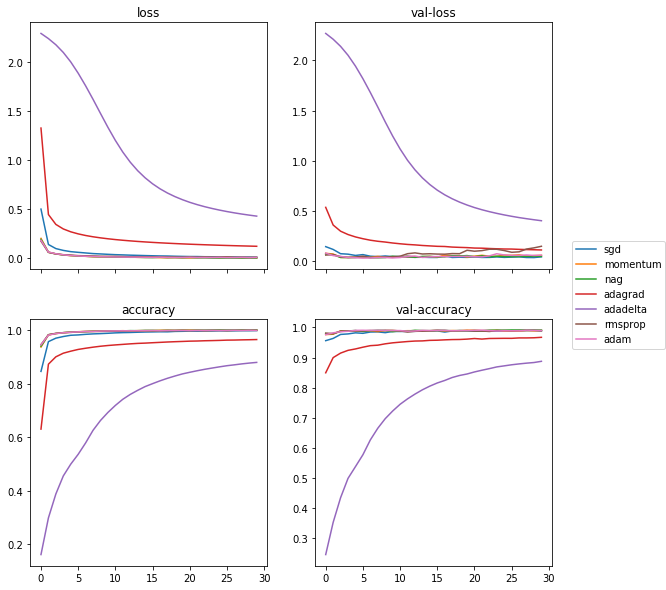

In [18]:
fig, ax = plt.subplots(2, 2, figsize=(10,10), sharex='col')
ax[0, 0].set_title("loss")
ax[0, 1].set_title("val-loss")
ax[1, 0].set_title("accuracy")
ax[1, 1].set_title("val-accuracy")

lines, labels = [], []
for optimiser_Name in history_per_optimiser:
    history = history_per_optimiser[optimiser_Name]
    ax[0, 0].plot(history.history['loss'])
    ax[0, 1].plot(history.history['val_loss'])
    ax[1, 0].plot(history.history['accuracy'])
    line = ax[1, 1].plot(history.history['val_accuracy'])
    lines.append(line[0])
    labels.append(optimiser_Name)

fig.legend(lines,labels, loc='center right', borderaxespad=0.1)
plt.subplots_adjust(right=0.85)

### Conclusion:

Examining the results from the charts above, and focusing on the validation accuracy graph, it can be seen that majority of the modern optimisers and the standard SGD achieved better results when compared to the Adadelta algorithm. Taking a look at the curve of the lines, these algorithms converges to a solution uch faster than Adadelta algorithm was able to. The Adadelta algorithm can be seen to be significantly slower at convergence by a huge amount. Overall, using these algorithms (aside from Adadelta) can prove to be invaluable in practice as they were able to gain a higher accuracy in their predictions. 

## 5 - Adding Regularisation to the Model:

## 5.1 - What is Regularisation?

Previously covered sections mainly trains the models to minimise the loss function to update the network weights in order to obtain better accuracies over time. Regularly, the model may need further improvements to be applied to prevent the model from overfitting the data. Overfitting is undesired because when the trained model recevies new unknown data to classify, it won't be able to perform with the same accuracy. The idea here, is to employ techniques to prevent overfitting so that the model can generalise well. 

Methods without regularisation can be:
1) Training the model on a Rich dataset, this provides enough variability from the data to improve the model's performance during testing scenarios. \
2) Change the model architecture with experiments, ensuring that the model is not too shallow to avoid underfitting or too deep to prevent overfitting. 

Regularistion techniques are:
1) Early Stopping. \
2) L1 and L2 Regularisation. \
3) Dropout. \
4) Batch Normalisation.

The following section will discuss more about these techniques.

## 5.2 - Early Stopping:

This straightforward technique essentially stops the model during training at a certain point (traininng epoch), this is to prevent overfitting as the model iterates over the dataset too many times, where ususally more common when the dataset has less training samples. The stopping point should be low enough to stop overfitting and large enough to ensure that the model can learn all that is needed. 

Cross-validation is the key to deciding on the early stopping point. This is done with providing a validation dataset to test the model on and through this validation, the network is able to measure if the training process should be continued or not.

Note: This can be automatically implemented with Keras Callbakcs, "tf.keras.callbacks.EarlyStopping".

## 5.3 - L1 and L2 Regularisation:

Generally, using regularisation in Machine Learning penalises the coefficients of the fitting function while in Deep Learning, the weight matrices of the nodes are the ones being penalised.

Mathematically, the regularisation term $R(P)$ is added to the loss function before training. This can be represened as the following:

$$ L(y, y^{true}) + \lambda R(P) $$ with $$ y = f(x, P) $$

Where, 
- $\lambda$ is the controlling factor for the strength of the regularisation term. 
- $y$ is the output of the function $f$ that is parameterised by $P$ for the input data $x$.

Next, the L1 and L2 regularisation terms can be defined as:

__For L1 Regularisation (a.k.a LASSO)__:

$$ R_{L1}(P) = \left\lvert \left\lvert P \right\rvert \right\rvert _{1} = \sum_{k} \left\lvert P_{k} \right\rvert$$

In more detail, the L1 Regulariser (LASSO, Least Absolute Shrinkage and Selection Operator) makes the network minimise the sum of its absolute parameter values. The larger weights are not penalised by the squaring factor, where instead it shrinks the parameters that are linked to the less important feature towards zero. Essentially, the network will ignore the less meaningful features, adopting sparse parameters. This technique is also useful when being applied to models that needs to run on mobile applications.

__For L2 Regularisaiton (a.k.a RIDGE)__:

$$ R_{L2}(P) = \frac{1}{2} \left\lvert \left\lvert P \right\rvert \right\rvert _{1}^{2} = \sum_{k} \frac{1}{2}  \left\lvert P_{k}^{2} \right\rvert$$

In more detail, the L2 Regulariser (RIDGE) makes the network minimise the sum of its squared parameter values. This technique will decay all of the parameter values but it does so more strongly on large parameters (because of the squared term). Essentially, the network will keep its parameter values low and therefore it will be more homogeneously distributed. This technique prevents the network from developing a small set of parameters that has large values which influences the predictions.

The Code implementations for these will be shown in the sections below.

## 5.4 -







## Summary:

